# Data Wrangling & EDA

## 1 Table of Contents

- [1 Table of Contents](#1-Table-of-Contents)
- [2 Introduction](#2-Introduction)
- [3 Setup](#3-Setup)
- [4 Data Verification](#4-Data-Verification)
- [5 Distributions](#5-Distributions)
  - [5.1 Labels](#5.1-Labels)
  - [5.2 Words](#5.2-Words)
- [6 Simple Cleaning and Preprocessing](#6-Simple-Cleaning-and-Preprocessing)
  - [6.1 Common Words](#6.1-Common-Words)
- [7 Conclusion](#7-Conclusion)
  - [7.1 Data Wrangling](#7.1-Data-Wrangling)
  - [7.2 Exploratory Data Analysis](#7.2-Exploratory-Data-Analysis)
  - [7.3 Findings](#7.3-Findings)
  - [7.4 Save Files](#7.4-Save-Files)

## 2 Introduction

The dataset for this project is from [Kaggle](https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles) and was scraped by Analytics Vidhya, which is a community of data professionals. It provides two CSV files, 'train.csv' and 'test.csv'. The 'train.csv' contains 20,972 article samples with nine columns: a unique ID, the title, and the abstract, and the six topic columns corresponding to different science subjects. The 'test.csv' contains 8989 articles and the first three columns are the same as those from the 'train.csv', but the 'test.csv' articles are not labeled with topics.

This notebook will encompass some data wrangling and exploratory data analysis. Although the text will be somewhat processed here, there will be more in the following notebook. Here, we seek a broad understanding of the data.

## 3 Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
from collections import Counter
import re
from wordcloud import WordCloud

In [2]:
train_df = pd.read_csv("../data/raw/train.csv")
print("Train shape: ", train_df.shape)
test_df = pd.read_csv("../data/raw/test.csv")
print("Test shape: ", test_df.shape)

Train shape:  (20972, 9)
Test shape:  (8989, 3)


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [4]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


In [6]:
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [7]:
print(train_df.sample(2)[['TITLE', 'ABSTRACT']].values)

[['$η$-metric structures'
  '  In this paper, we discuss recent results about generalized metric spaces and\nfixed point theory. We introduce the notion of $\\eta$-cone metric spaces, give\nsome topological properties and prove some fixed point theorems for contractive\ntype maps on these spaces. In particular we show that theses $\\eta$-cone metric\nspaces are natural generalizations of both cone metric spaces and metric type\nspaces.\n']
 ['A Broader View on Bias in Automated Decision-Making: Reflecting on Epistemology and Dynamics'
  '  Machine learning (ML) is increasingly deployed in real world contexts,\nsupplying actionable insights and forming the basis of automated\ndecision-making systems. While issues resulting from biases pre-existing in\ntraining data have been at the center of the fairness debate, these systems are\nalso affected by technical and emergent biases, which often arise as\ncontext-specific artifacts of implementation. This position paper interprets\ntechnical 

Some of the texts contain "\n" for new lines and \$ for special formatting.

## 4 Data Verification

After loading the data, we will check if the data looks okay. There should be no missing values, and the dataframes should be populated by reasonable values. The `info` for the dataframes earlier did not show any nulls. (Empty fields will be checked below.)

In [8]:
train_df['ID'].is_unique & train_df['TITLE'].is_unique & train_df['ABSTRACT'].is_unique

True

In [9]:
train_df.describe()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
for c in train_df.columns[3:]:
    print(train_df[c].value_counts())

0    12378
1     8594
Name: Computer Science, dtype: int64
0    14959
1     6013
Name: Physics, dtype: int64
0    15354
1     5618
Name: Mathematics, dtype: int64
0    15766
1     5206
Name: Statistics, dtype: int64
0    20385
1      587
Name: Quantitative Biology, dtype: int64
0    20723
1      249
Name: Quantitative Finance, dtype: int64


The numeric columns make sense, and the topic columns contain only 0 and 1.

The information provided from the `test_df` may possibly still be used, so we will give its data a cursory check as well.

In [11]:
test_df['ID'].is_unique & test_df['TITLE'].is_unique & test_df['ABSTRACT'].is_unique

True

## 5 Distributions

### 5.1 Labels

Let's check the label distributions.

In [12]:
# The `labels` list will hold the names of the topics
labels = train_df.columns[3:]

In [13]:
def count_labels(labels, df, print_counts=True):
    """
    Counts the number of articles marked with a label.
    
    labels : A list of column names.
    df : The DataFrame of articles with labels to count.
    print_counts : If set to true, it will print the labels and their occurrences.
    """
    label_count = []
    for label in labels:
        label_sum = df[label].sum()
        label_count.append(label_sum)
        if (print_counts):
            print("{} articles tagged with {}".format(label_sum, label))
    return label_count

def plot_topic_labels(labels, label_count):
    """
    Plots a bar chart for the label counts.
    
    labels : A list of the names of the labels
    label_count : A list of occurrences corresponding to the labels
    """
    _ = plt.figure(figsize=(15,5))
    _ = plt.title("Number of articles per topic")
    _ = plt.xlabel("Topic")
    _ = plt.ylabel("Number of articles")
    _ = plt.bar(labels, label_count)

(Admittedly, defining something like `count_labels()` could be forgone.)

8594 articles tagged with Computer Science
6013 articles tagged with Physics
5618 articles tagged with Mathematics
5206 articles tagged with Statistics
587 articles tagged with Quantitative Biology
249 articles tagged with Quantitative Finance


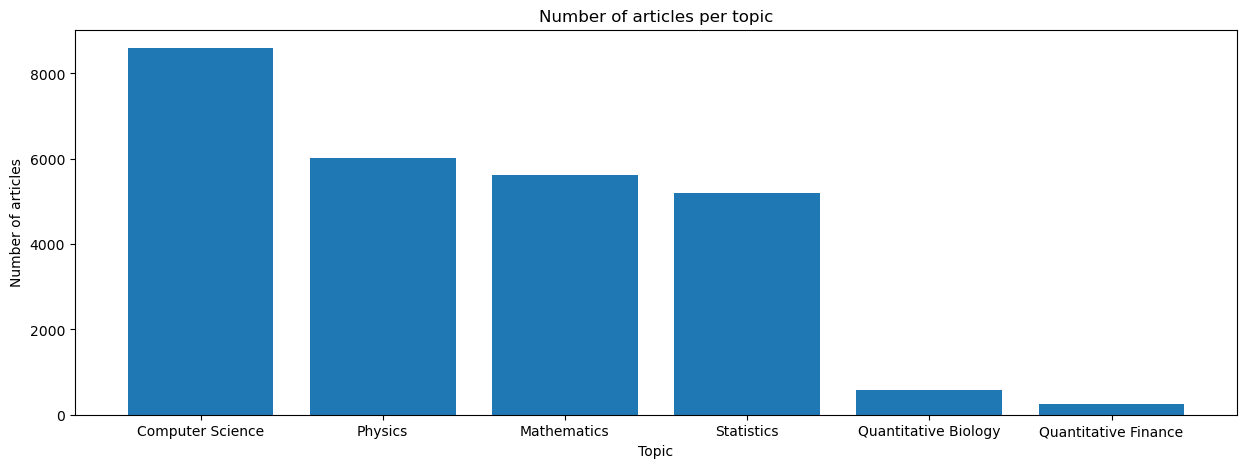

In [14]:
labels_per_topic = count_labels(labels, train_df)
plot_topic_labels(labels, labels_per_topic)

The classes are imbalanced, with 'Quantitative Biology' and 'Quantitative Finance' having relatively few articles tagged with those topics. Meanwhile, a lot of articles were marked with 'Computer Science'.

The articles could be labeled with more than one topic, so we will also check how these multi-topic articles are distributed.

In [15]:
print("Number of total tags: {}".format(np.sum(labels_per_topic)))

Number of total tags: 26267


There are 5295 more labels than there are articles, so about 25% of the labels were given to articles that already have at least one label.

In [16]:
num_nlabels = train_df.iloc[:,3:].aggregate(np.sum, axis=1).value_counts()
print("Number of articles with n labels:")
print(num_nlabels)

Number of articles with n labels:
1    15928
2     4793
3      251
dtype: int64


A little over 1% of articles are marked with three topics, about 23% are marked with two topics, and the remaining 76% have only one topic.

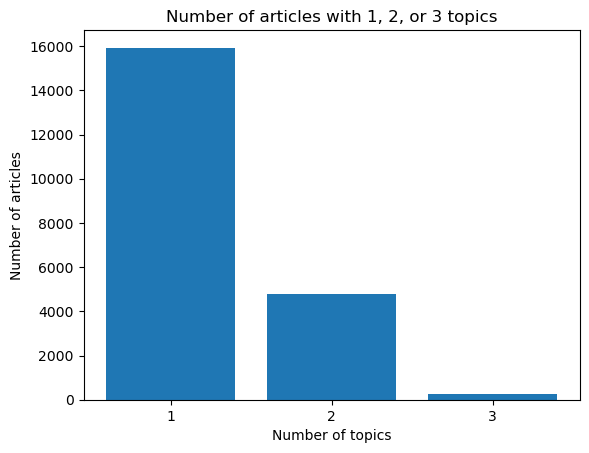

In [17]:
_ = plt.title("Number of articles with 1, 2, or 3 topics")
_ = plt.bar(num_nlabels.index, num_nlabels.values, tick_label=num_nlabels.index)
_ = plt.xlabel("Number of topics")
_ = plt.ylabel("Number of articles")
_ = plt.show()

### 5.2 Words

The text data is not cleaned yet, but we can approximate the word counts.

In [18]:
train_df['title_abstract'] = train_df['TITLE'] + train_df['ABSTRACT']
train_df.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...


In [19]:
test_df['title_abstract'] = test_df['TITLE'] + test_df['ABSTRACT']
test_df.head(3)

,ID,TITLE,ABSTRACT,title_abstract
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs Fr...


In [20]:
train_df['wps'] = train_df.apply(lambda x: len(re.findall(r'\w+', x['title_abstract'])), axis=1)
test_df['wps'] = test_df.apply(lambda x: len(re.findall(r'\w+', x['title_abstract'])), axis=1)

In [21]:
train_df.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract,wps
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...,287
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...,84
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,108


In [22]:
train_df.sample(2)[['title_abstract', 'wps']].values

array([['Some remarkable infinite product identities involving Fibonacci and Lucas numbers  By applying the classic telescoping summation formula and its variants to\nidentities involving inverse hyperbolic tangent functions having inverse powers\nof the golden ratio as arguments and employing subtle properties of the\nFibonacci and Lucas numbers, we derive interesting general infinite product\nidentities involving these numbers.\n',
        56],
       ['Physical Properties of Sub-galactic Clumps at 0.5 $\\leq z \\leq$ 1.5 in the UVUDF  We present an investigation of clumpy galaxies in the Hubble Ultra Deep Field\nat 0.5 $\\leq z \\leq$ 1.5 in the rest-frame far-ultraviolet (FUV) using HST WFC3\nbroadband imaging in F225W, F275W, and F336W. An analysis of 1,404 galaxies\nyields 209 galaxies that host 403 kpc-scale clumps. These host galaxies appear\nto be typical star-forming galaxies, with an average of 2 clumps per galaxy and\nreaching a maximum of 8 clumps. We measure the photometr

In [23]:
test_df.head(3)

,ID,TITLE,ABSTRACT,title_abstract,wps
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...,110
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...,155
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs Fr...,134


There are around 160 words per sample (now the `wps` column), with the samples being the combination of the title and the abstract. As expected, the samples themselves are fairly small, but we may assume that a well-written title and abstract should summarize the key points of a paper well.

In [24]:
train_df['wps'].describe()

count    20972.000000
mean       165.534284
std         64.414866
min          5.000000
25%        119.000000
50%        161.000000
75%        208.000000
max        467.000000
Name: wps, dtype: float64

In [25]:
test_df['wps'].describe()

count    8989.000000
mean      165.699855
std        64.869833
min        15.000000
25%       118.000000
50%       161.000000
75%       210.000000
max       429.000000
Name: wps, dtype: float64

The `describe` results highlight an unusual article in the 'train.csv' with only 5 words in the combined title and abstract, so we can check that quickly.

In [26]:
train_df.sort_values(by='wps').head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract,wps
16394,16395,Are theoretical results 'Results'?,Yes.\n,0,0,0,0,1,0,Are theoretical results 'Results'? Yes.\n,5
6262,6263,The CCI30 Index,We describe the design of the CCI30 cryptocu...,0,0,0,0,0,1,The CCI30 Index We describe the design of the...,12
4023,4024,Inner Cohomology of the General Linear Group,The main theorem is incorrectly stated.\n,0,0,1,0,0,0,Inner Cohomology of the General Linear Group ...,13
11024,11025,Deep Neural Networks - A Brief History,Introduction to deep neural networks and the...,1,0,0,0,0,0,Deep Neural Networks - A Brief History Introd...,14
19464,19465,Definitions in mathematics,We discuss various forms of definitions in m...,0,0,1,0,0,0,Definitions in mathematics We discuss various...,16


I am not an expert in quantitative biology, but its title and abstract do not look very descriptive or useful, so maybe it's better just to drop it.

In [27]:
train_df.drop(index=16394, inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [28]:
train_df['wps'].describe()

count    20971.000000
mean       165.541939
std         64.406862
min         12.000000
25%        119.000000
50%        161.000000
75%        208.000000
max        467.000000
Name: wps, dtype: float64

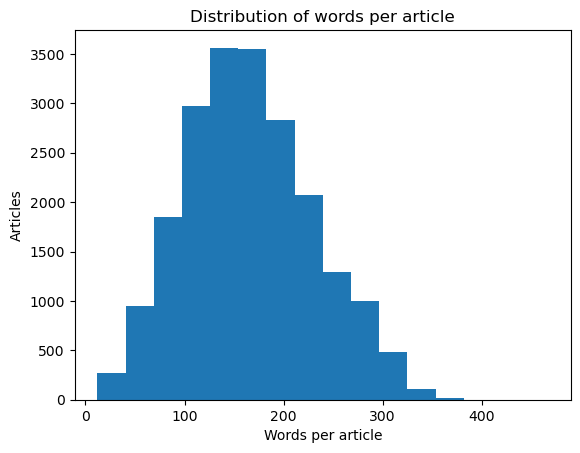

In [29]:
_ = plt.title("Distribution of words per article")
_ = plt.hist(train_df['wps'], bins=int(np.ceil(np.log2(len(train_df['wps']))) + 1))
_ = plt.xlabel("Words per article")
_ = plt.ylabel("Articles")
_ = plt.show()

Now comes the question, is there a big difference between the lengths of the titles and abstracts for each topic?

170.0 median words in Computer Science articles
173.0 median words in Physics articles
121.0 median words in Mathematics articles
166.0 median words in Statistics articles
193.0 median words in Quantitative Biology articles
147.0 median words in Quantitative Finance articles


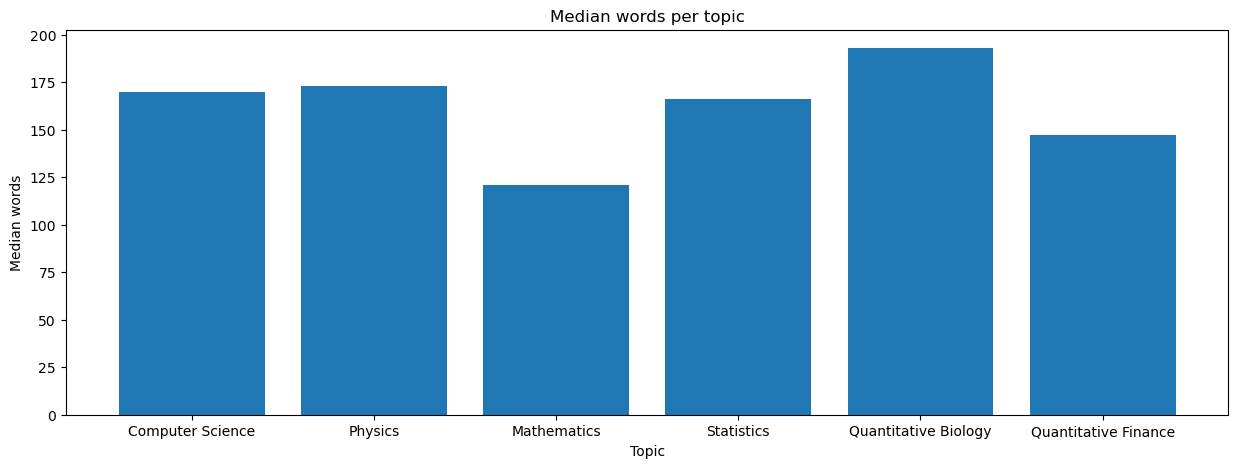

In [30]:
wps_med = []
for label in labels:
    lmed = train_df[train_df[label] == 1]['wps'].median()
    print("{} median words in {} articles".format(lmed, label))
    wps_med.append(lmed)

_ = plt.figure(figsize=(15,5))
_ = plt.title("Median words per topic")
_ = plt.bar(labels, wps_med)
_ = plt.xlabel("Topic")
_ = plt.ylabel("Median words")
_ = plt.show()

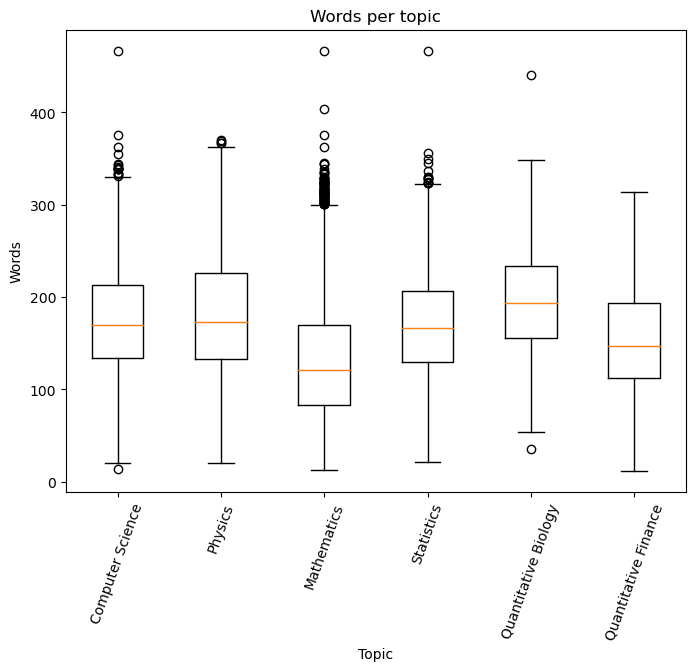

In [31]:
wps_per_cat = []
for label in  labels:
    wps_per_cat.append(train_df[train_df[label] == 1]['wps'])

_ = plt.figure(figsize=(8,6))
_ = plt.title("Words per topic")
_ = plt.boxplot(wps_per_cat, labels=labels)
_ = plt.xticks(rotation=70)
_ = plt.xlabel("Topic")
_ = plt.ylabel("Words")

It seems that 'Mathematics' articles generally use the fewest words in their titles and abstracts, whereas the 'Quantitative Biology' articles have more words. The range between the medians of these two is 72. The rest tend to fall somewhere in between them.

## 6 Simple Cleaning and Preprocessing

The method, [`gensim.utils.simple_preprocess`](https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess), can be used to convert a document into a list of lowercase tokens. We will remove stopwords, for which we will use [`nltk.corpus`](https://www.nltk.org/api/nltk.corpus.html#module-nltk.corpus)'s `stopwords`, and we will lemmatize the tokens to group inflected words with [`nltk.stem.WordNetLemmatizer()`](https://www.nltk.org/_modules/nltk/stem/wordnet.html).

In [32]:
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess(doc):
    """
    Converts a single document into a list of tokens.
    
    doc : A document of text (strings)
    """
    # Convert to a list of lowercase tokens
    tokens = simple_preprocess(doc, deacc=True)
    # Remove stopwords
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    # Lemmatize tokens
    lemma_tokens = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    return lemma_tokens

In [33]:
## This can take 10-15 min, so commented out
#time_start = time.time()
#train_df['text'] = train_df.apply(lambda x: preprocess(x['title_abstract']), axis=1)
#time_end = time.time()
#time_elapsed = time_end - time_start
#print("Time elapsed for text preprocessing on Training Set: {} sec".format(time_elapsed))

In [34]:
## This can take ~5 min, so commented out
#time_start = time.time()
#test_df['text'] = test_df.apply(lambda x: preprocess(x['title_abstract']), axis=1)
#time_end = time.time()
#time_elapsed = time_end - time_start
#print("Time elapsed for text preprocessing on Test Set: {} sec".format(time_elapsed))

In [35]:
#train_df.to_pickle("../data/interim/1-0_train_clean.pkl")
#test_df.to_pickle("../data/interim/1-0_test_clean.pkl")

In [36]:
train_df_clean = pd.read_pickle("../data/interim/1-0_train_clean.pkl")
test_df_clean = pd.read_pickle("../data/interim/1-0_test_clean.pkl")

In [37]:
train_df_clean.sample(1)['text'].values

array([list(['halo', 'nonlinear', 'reconstruction', 'apply', 'nonlinear', 'reconstruction', 'method', 'simulated', 'halo', 'field', 'halo', 'number', 'density', 'time', 'rm', 'mpc', 'corresponding', 'sd', 'main', 'sample', 'density', 'find', 'scale', 'noise', 'saturates', 'linear', 'signal', 'improved', 'gtrsim', 'rm', 'mpc', 'factor', 'improvement', 'scale', 'number', 'linear', 'mode', 'improvement', 'le', 'higher', 'redshift', 'lower', 'halo', 'density', 'expect', 'substantially', 'improve', 'bao', 'accuracy', 'dense', 'low', 'redshift', 'survey', 'including', 'sd', 'main', 'sample', 'dfgs', 'cm', 'intensity', 'mapping', 'initiative'])],
      dtype=object)

### 6.1 Common Words

Now that the words have been normalized, tokenized, and lemmatized, we can look at the word counts.

In [38]:
def get_top_n(text_series, n=None, ignore_list=[]):
    """
    Counts the top n most common tokens and returns them as a dictionary.
    
    text_series : A series of tokens to count.
    n : The number of most common tokens to return.
    ignore_list : A list of terms to ignore when counting.
    """
    token_counter = Counter()
    for t in text_series:
        if ignore_list:
            token_counter.update([t_i for t_i in t if t_i not in ignore_list])
        else:
            token_counter.update(t)
    top_n_tokens_dict = dict(token_counter.most_common(n))
    
    return top_n_tokens_dict

{'model': 18006, 'data': 12021, 'method': 11825, 'network': 11474, 'system': 10207, 'result': 9824, 'problem': 9576, 'based': 9493, 'time': 9271, 'show': 8846}


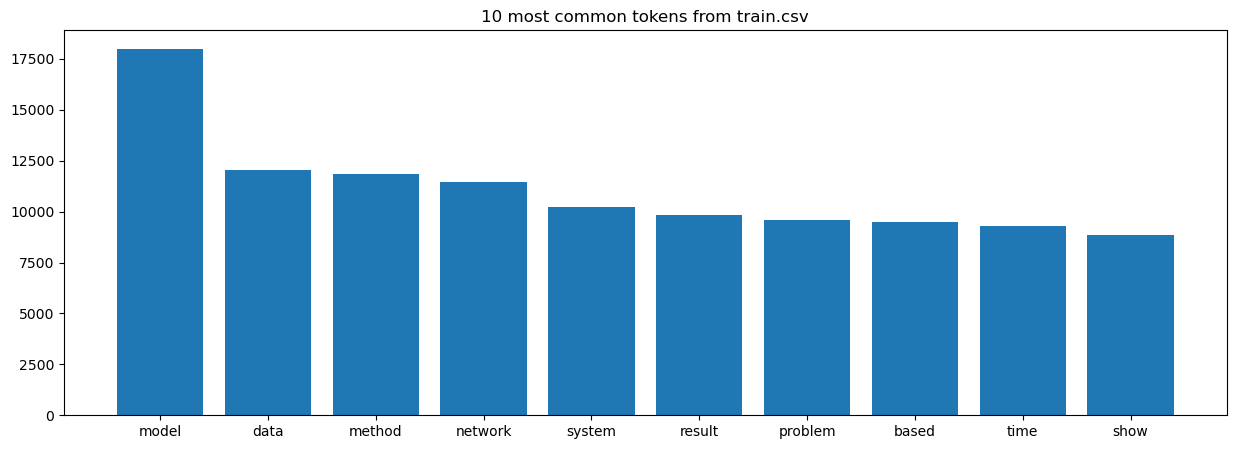

In [39]:
train_top10 = get_top_n(train_df_clean['text'], n=10)

print(train_top10)

_ = plt.figure(figsize=(15,5))
_ = plt.title("10 most common tokens from train.csv")
_ = plt.bar(train_top10.keys(), train_top10.values())

{'model': 7793, 'data': 5051, 'network': 4975, 'method': 4800, 'system': 4410, 'result': 4180, 'based': 3998, 'problem': 3957, 'time': 3894, 'using': 3811}


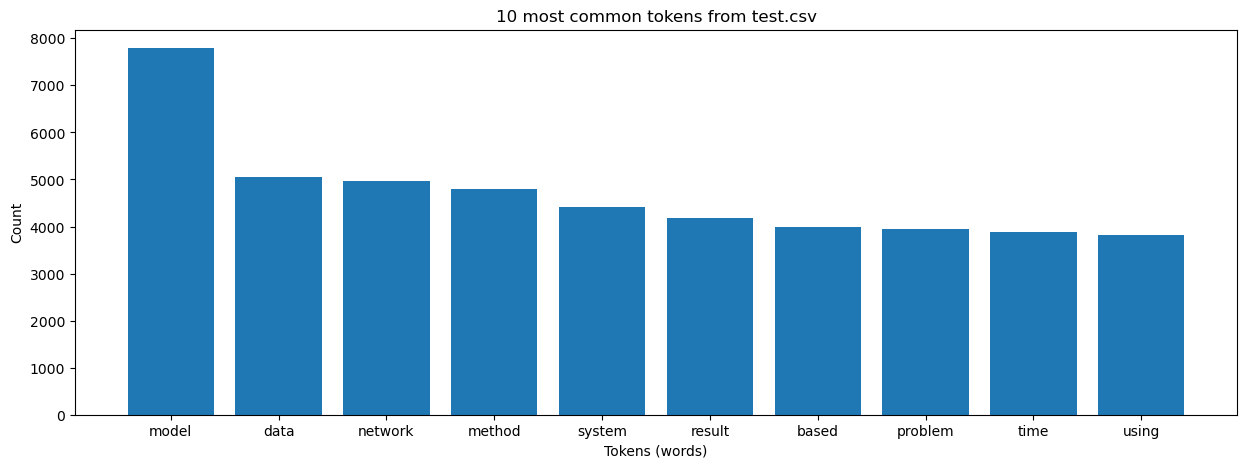

In [40]:
test_top10 = get_top_n(test_df_clean['text'], n=10)

print(test_top10)

_ = plt.figure(figsize=(15,5))
_ = plt.title("10 most common tokens from test.csv")
_ = plt.bar(test_top10.keys(), test_top10.values())
_ = plt.xlabel("Tokens (words)")
_ = plt.ylabel("Count")
_ = plt.show()

Between the "train.csv" and "test.csv", the top ten most commmonly used words were similar, with nine out of ten words being the same though at different ranks. Next we will check the top five words per topic.

In [41]:
label_top5 = []
for label in labels:
    top5 = get_top_n(train_df_clean[train_df_clean[label] == 1]['text'], n=5)
    label_top5.append(top5)
    print("{}: {}".format(label, top5))

Computer Science: {'model': 8485, 'network': 8420, 'data': 6830, 'method': 6338, 'algorithm': 6219}
Physics: {'model': 4512, 'system': 3514, 'field': 3054, 'time': 2866, 'two': 2743}
Mathematics: {'problem': 2935, 'result': 2762, 'function': 2638, 'model': 2466, 'space': 2221}
Statistics: {'model': 7483, 'data': 5888, 'learning': 5113, 'method': 5107, 'network': 4771}
Quantitative Biology: {'model': 811, 'network': 761, 'data': 464, 'method': 392, 'cell': 364}
Quantitative Finance: {'model': 459, 'market': 285, 'price': 218, 'time': 187, 'risk': 158}


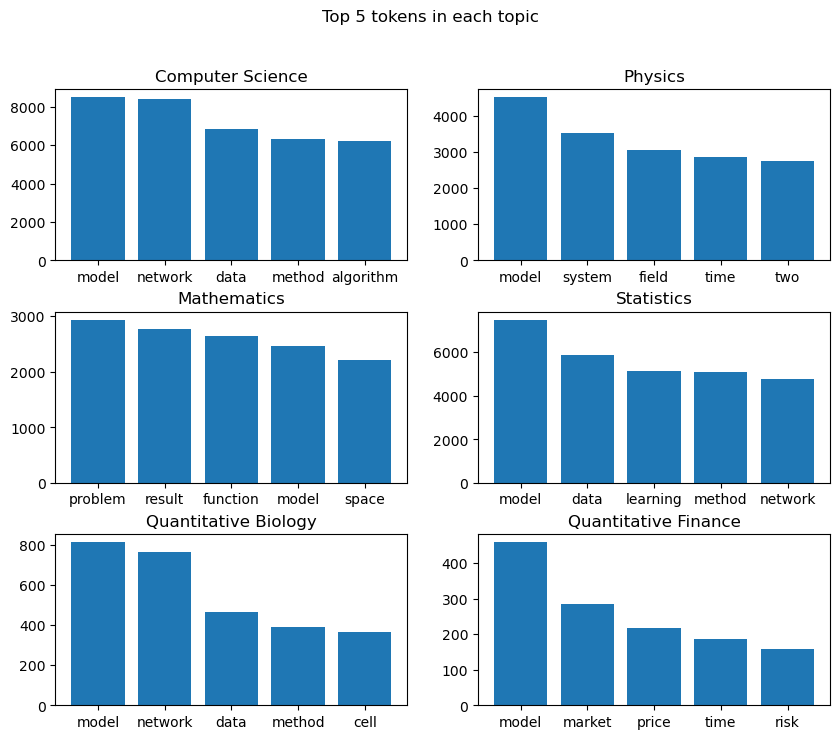

In [42]:
fig, axs = plt.subplots(3, 2, figsize=(10,8), gridspec_kw={'hspace':0.3})

i = 0
for row in range(0,3):
    for col in range(0,2):
        _ = axs[row, col].set_title(labels[i])
        _ = axs[row, col].bar(label_top5[i].keys(), label_top5[i].values())
        i += 1

_ = fig.suptitle("Top 5 tokens in each topic")
_ = plt.show()

These word counts do not have too much thought about overall word frequency. A lot of these words are clearly generic "science article" words, so showing the most common words by topic is not so unique to or descriptive of a topic. These generic terms can be likened to stopwords specific to this problem space. However, there is a little bit of expression present even in this sort of basic counter: in each topic, there are 2-4 unique words.

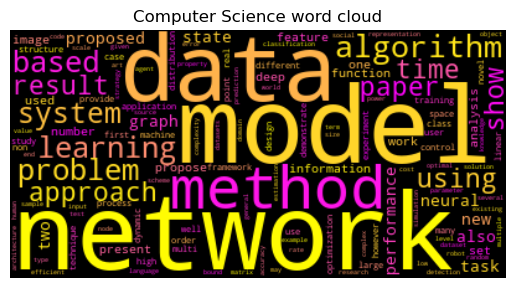

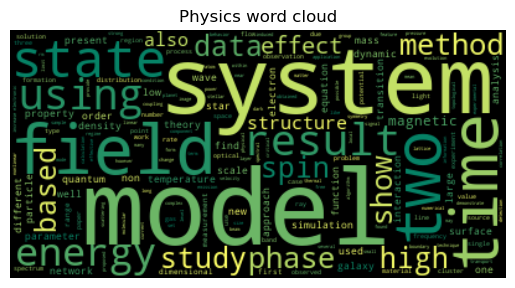

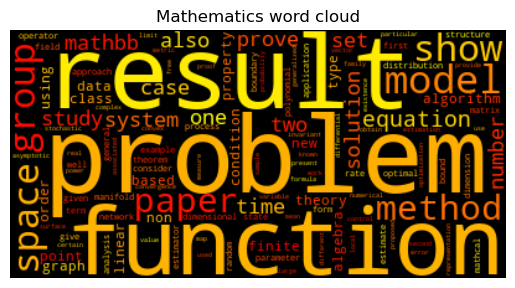

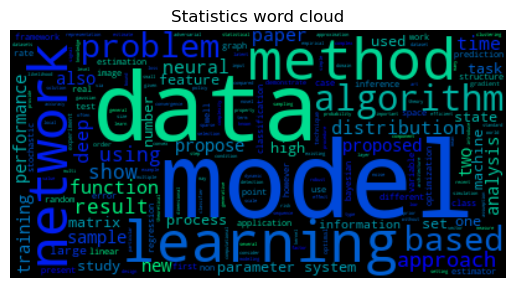

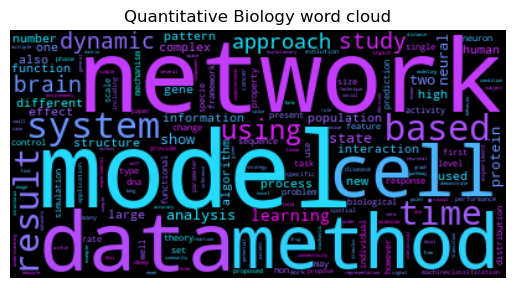

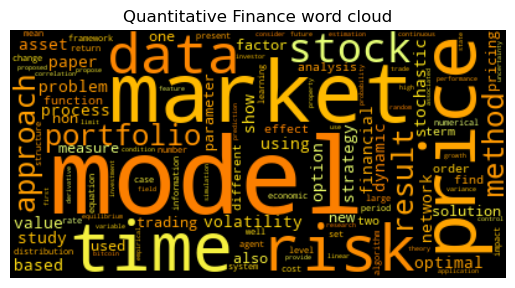

In [43]:
colormaps=['spring','summer','autumn','winter','cool','Wistia']
i = 0

for label in labels:
    top_rmv = get_top_n(train_df_clean[train_df_clean[label] == 1]['text'])
    wc = WordCloud(background_color="black", colormap=colormaps[i], max_words=200, max_font_size=85)
    i += 1
    wc.generate_from_frequencies(top_rmv)
    plt.title("{} word cloud".format(label))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

We can quickly reuse some code and variables that we already have to filter out the ten most common global words and check the common topic-specific words again. There are more sophisticated methods of judging and selecting words (such as tfidf), but these will be explored in the next notebook.

Computer Science: {'algorithm': 6219, 'learning': 5927, 'approach': 4472, 'using': 4377, 'paper': 4354}
Physics: {'field': 3054, 'two': 2743, 'state': 2738, 'using': 2485, 'energy': 2420}
Mathematics: {'function': 2638, 'space': 2221, 'group': 2182, 'paper': 2088, 'equation': 1956}
Statistics: {'learning': 5113, 'algorithm': 3794, 'approach': 2785, 'using': 2576, 'paper': 2224}
Quantitative Biology: {'cell': 364, 'using': 274, 'dynamic': 273, 'study': 267, 'brain': 264}
Quantitative Finance: {'market': 285, 'price': 218, 'risk': 158, 'stock': 129, 'portfolio': 129}


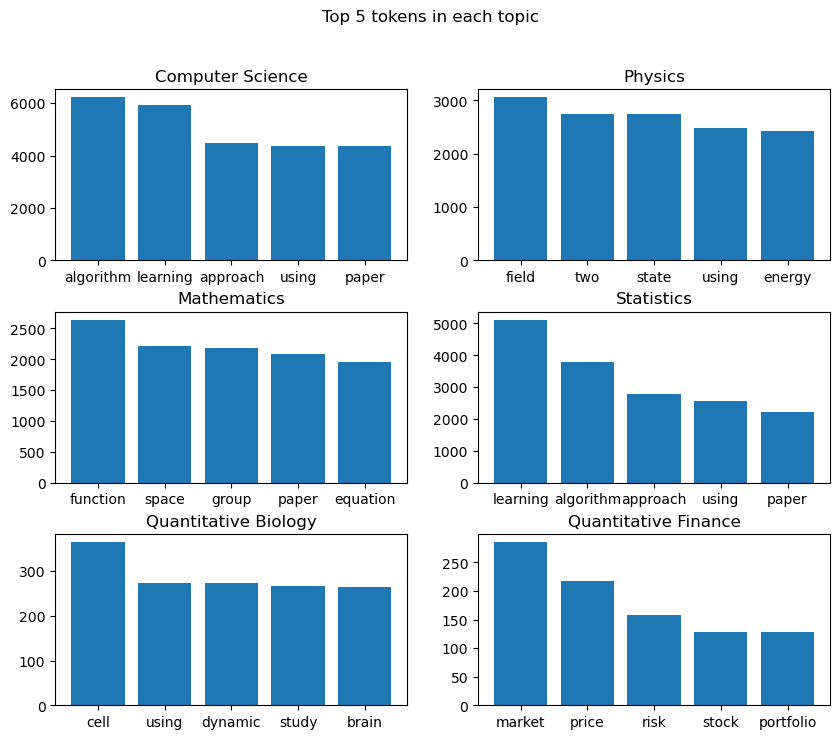

In [44]:
label_top5_rmv = []
for label in labels:
    top5_rmv = get_top_n(train_df_clean[train_df_clean[label] == 1]['text'], n=5, ignore_list=train_top10.keys())
    label_top5_rmv.append(top5_rmv)
    print("{}: {}".format(label, top5_rmv))

fig, axs = plt.subplots(3, 2, figsize=(10,8), gridspec_kw={'hspace':0.3})

i = 0
for row in range(0,3):
    for col in range(0,2):
        _ = axs[row, col].set_title(labels[i])
        _ = axs[row, col].bar(label_top5_rmv[i].keys(), label_top5_rmv[i].values())
        i += 1

_ = fig.suptitle("Top 5 tokens in each topic")
_ = plt.show()

'Quantitative Biology' gained the most from this. Of all the topics, the 'Quantitative Biology' and 'Quantitative Finance' have more characteristic terms in their top five most common words. This is probably because of their small sample sizes and the granularity of their topics, whereas the other four are rather broad subjects. With such a rudimentary filter, we see some more characteristics shine through each topic's word counts.

Below, 30 of the most common words are filtered out, so it is slightly more aggressive than the results above.

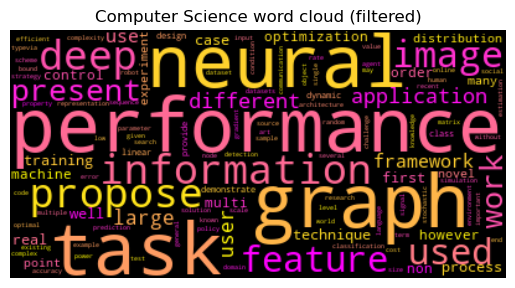

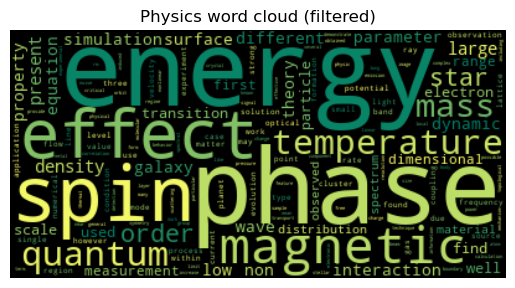

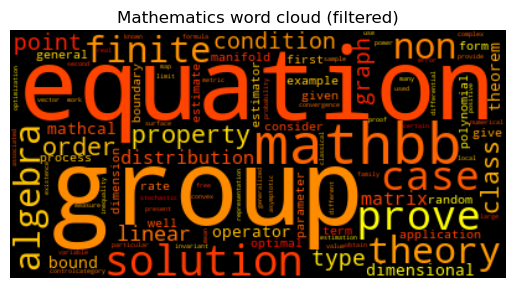

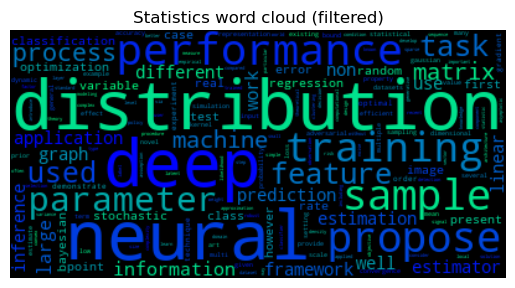

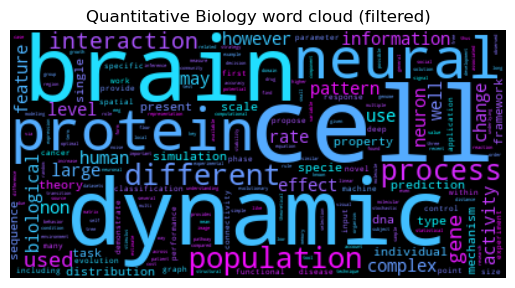

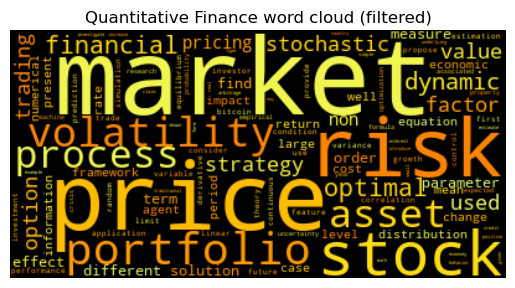

In [45]:
colormaps=['spring','summer','autumn','winter','cool','Wistia']
i = 0

for label in labels:
    top_rmv = get_top_n(train_df_clean[train_df_clean[label] == 1]['text'],
                        ignore_list=get_top_n(train_df_clean['text'], n=30).keys())
    wc = WordCloud(background_color="black", colormap=colormaps[i], max_words=200, max_font_size=85)
    i += 1
    wc.generate_from_frequencies(top_rmv)
    plt.title("{} word cloud (filtered)".format(label))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## 7 Conclusion

The purpose of this notebook was to verify and clean the data and to explore features and their interactions with one another or with the response variable.

### 7.1 Data Wrangling

As would be standard across any sort of dataset, the integrity was verified by assessing for duplicates and null or empty values, but luckily this dataset is very clean and tidy. However, there was one suspicious sample, which only contained five words in the concatenation of the title and abstract, and these five words did not seem very indicative of its topic or important, so it was dropped.

Some light text cleaning and preprocessing were conducted on the title and abstract concatenations. Using gensim and NLTK, the texts were converted into lowercase tokens, stopwords were removed, and the resulting pruned lists of words were lemmatized. This process took 10-15 minutes for the 'train.csv' and 5 minutes for the 'test.csv'.

### 7.2 Exploratory Data Analysis

The distributions and frequencies of topic labels, articles, and words were examined.

The dataset is imbalanced, with 'Quantitative Biology' and 'Quantitative Finance' having very few samples, whereas 'Computer Science' has plentiful samples. (Note, the percentages below will not add up to 100% because articles can be labeled with more than one topic.)

| Topic label | Articles per topic | % articles |
| --- | --- | --- |
| Computer Science | 8594 | 40.9% |
| Physics | 6013 | 28.7% |
| Mathematics | 5618 | 26.7% |
| Statistics | 5206 | 24.8% |
| Quantitative Biology | 587 | 2.8% |
| Quantitative Finance | 249 | 1.2% |

There are 26,267 total labels overall, so there are 5,295 more labels than there are articles. This means that about 25% of the labels were given to articles that already have at least one label. A little over 1% of the articles were marked with three topics, 23% with two, and 76% with only one.

| *n* | Labels per article |
| --- | --- |
| 1 | 15928 |
| 2 | 4793 |
| 3 | 251 |

Overall, the median words per sample (wps), where a sample in this case is the concatenation of the title and abstract, is 161. 'Quantitative Biology' usually had lengthier samples, whereas 'Mathematics' had shorter samples, and most fell somewhere in between these two. Interestingly albeit likely unsurprisingly, the order of these sample lengths follows intuitive similarity, as the topics closer to 'Mathematics' are shorter, whereas 'Physics' is second to 'Quantitative Biology' in length. The medians for each topic label can be seen in the table below.

| Topic label | Median wps |
| --- | --- |
| Computer Science | 170 |
| Physics | 173 |
| Mathematics | 121 |
| Statistics | 166 |
| Quantitative Biology | 193 |
| Quantitative Finance | 147 |

The ten most common words between the 'train.csv' and 'test.csv' were very similar, so only the 'train.csv' will be discussed here. The words are certainly related to science articles, which at the very least verifies that the articles are mostly about science, but these most common words do not tell us very much about the topics.

| Word | model | data | method | network | system | result | problem | based | time | show |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Count** | 18006 | 12021 | 11825 | 11474 | 10207 | 9824 | 9576 | 9493 | 9271 | 8846 |

Thus, the five most common words of the topics can be examined. There is still a lot of overlap among the topics, and the specific characteristics that may define the topics do not express very well like this.

| Topic label | #1 word | #1 count | #2 word | #2 count | #3 word | #3 count | #4 word | #4 count | #5 word | #5 count |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Computer Science** | model | 8485 | network | 8420 | data | 6830 | method | 6338 | algorithm | 6219 |
| **Physics** | model | 4512 | system | 3514 | field | 3054 | time | 2866 | two | 2743 |
| **Mathematics** | problem | 2935 | result | 2762 | function | 2638 | model | 2466 | space | 2221 |
| **Statistics** | model | 7483 | data | 5888 | learning | 5113 | method | 5107 | network | 4771 |
| **Quantitative Biology** | model | 811 | network | 761 | data | 464 | method | 392 | cell | 364 |
| **Quantitative Finance** | model | 459 | market | 285 | price | 218 | time | 187 | risk | 158 |

### 7.3 Findings

Perhaps most significantly, the datasets are imbalanced in terms of the response variable; there are a lot of 'Computer Science' articles and very few 'Quantitative Biology' and 'Quantitative Finance' articles. In classification, dataset imbalance can cause models to make incorrect predictions for the underrepresented variables. The simple text preprocessing done here illustrates that the word frequency given all the documents may be an important consideration when selecting features to model. There are a lot of shared words in the articles across the different topics beyond simple stopwords. Further NLP processes will be explored in the next notebook.

### 7.4 Save Files

In [46]:
train_df.iloc[:,3:10].to_pickle("../data/interim/1-1_train.pkl")
train_df.iloc[:,3:10].to_pickle("../data/interim/1-1_test.pkl")